In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx

from tqdm import tqdm
import typing as tp
import pandas as pd

import sys

import optax
import numpyro.distributions as D

from diffcv.mcmc import ULASampler
from diffcv.cv import CVLinear, CVMLP, CVTrainer, CVLoss, CVALSLoss, DiffLoss
from diffcv.logger import Logger
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv import ScalarGenerator
from diffcv.mcmc import Estimator
from diffcv.cv.nn import init_linear, normal_init

sns.set_style("darkgrid")

def plot_log_results(logger: Logger, log_scale=False):
    log_results = logger.to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    lr = sns.lineplot(data=log_results["learning_rate"], ax=axes[0])
    loss = sns.lineplot(data=log_results["loss"], ax=axes[1])
    if log_scale:
        lr.set(yscale="log")
        loss.set(yscale="log")
    fig.show()

2024-08-06 14:12:35.093978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 14:12:35.094011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 14:12:35.094032: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 14:12:35.814727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
DIST_DIM = 10 # Dimension of a Gaussian
N_CHAINS = 100 # Number of parallel chains for MCMC estimates
MCMC_N_ESTIMATES = 1000 # Number of MCMC estimates to calculate CI
BATCH_SIZE = 256 # Batch size for CV training

rng = jax.random.PRNGKey(50)

dist = D.MultivariateNormal(loc=10 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float))
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
true_pi = (dist.mean ** 2).sum() + (dist.variance ** 2).sum()

rng, key = jax.random.split(rng)
sampler = ULASampler(grad_log_prob=grad_log_prob, dim=DIST_DIM, n_samples=100, gamma=5e-2, burnin_steps=100, init_std=5.0)

2024-08-06 14:12:37.942542: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
def train(rng: jax.random.PRNGKey, loss_fn: str="cv", n_steps=30_000, switch_steps=5000, l2_alpha: float=0.0, optim: str="sgd"):
    rng, key = jax.random.split(rng)
    dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=N_CHAINS)
    print(len(dataset))

    rng, key = jax.random.split(rng)
    cv_model = CVMLP(in_size=DIST_DIM, depth=0, width_size=0, activation=jax.nn.elu, key=key)

    # rng, key = jax.random.split(rng)
    # cv_model = init_linear(cv_model, key, normal_init)

    scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=20_000, decay_rate=0.9)
    if optim == "sgd":
        optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler)
    elif optim == "adam":
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
        l2_alpha = 0.0
    
    if loss_fn == "cv":
        loss = CVLoss(fn=fn, l2_alpha=l2_alpha)
    elif loss_fn == "cv_als":
        loss = CVALSLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0, switch_steps=switch_steps, l2_alpha=l2_alpha)
    elif loss_fn == "diff":
        loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

    logger = Logger()

    cv_trainer = CVTrainer(cv_model, dataloader, optimizer, loss, logger, n_steps=n_steps)

    rng, key = jax.random.split(rng)
    cv_model = cv_trainer.train(key)

    plot_log_results(logger, log_scale=False)
    
    return cv_model

In [5]:
rng, key = jax.random.split(rng)
base_estimates = Estimator(fn, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)
bias = true_pi - base_estimates.mean()
std = base_estimates.std()
print("base:", bias, std)

  0%|          | 0/1000 [00:00<?, ?it/s]

base: 2.1644287 3.682595


10000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diffcv: -0.152771 0.4433611


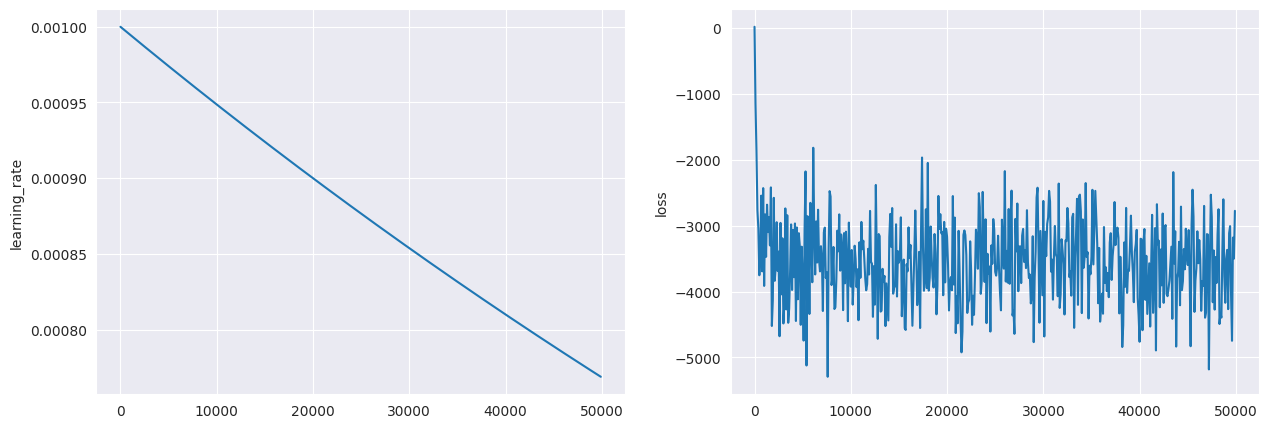

In [6]:
rng, key = jax.random.split(rng)
cv_model = train(key, loss_fn="cv", n_steps=50_000, l2_alpha=0.0, optim="sgd")

generator = ScalarGenerator(grad_log_prob, cv_model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
cv_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

bias = true_pi - cv_estimates.mean()
std = cv_estimates.std()
print("diffcv:", bias, std)

10000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diffcv: -0.3357544 0.28954598


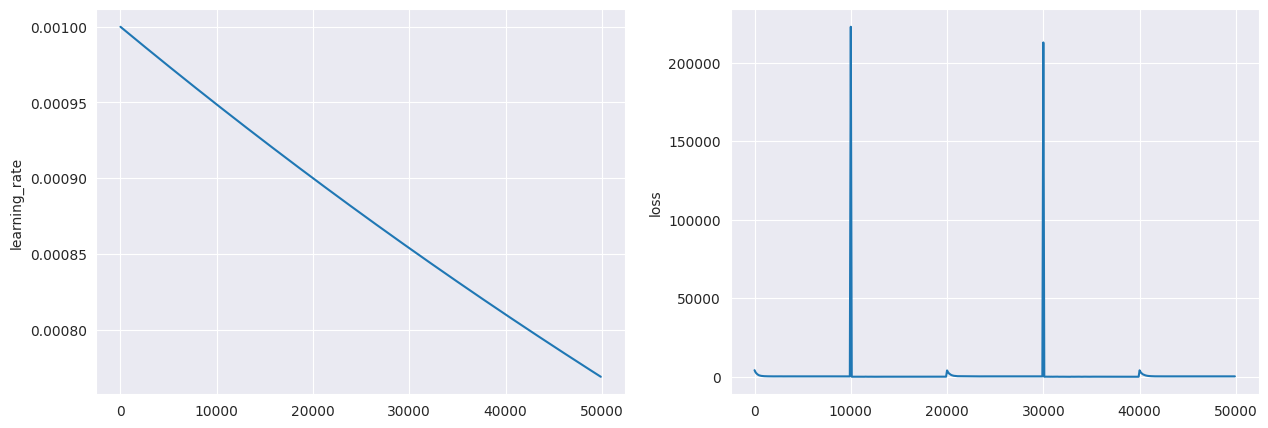

In [7]:
rng, key = jax.random.split(rng)
cv_model = train(key, loss_fn="cv_als", n_steps=50_000, switch_steps=10_000, l2_alpha=50.0)

generator = ScalarGenerator(grad_log_prob, cv_model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
cv_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

bias = true_pi - cv_estimates.mean()
std = cv_estimates.std()
print("diffcv:", bias, std)

10000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diff: -0.24047852 0.25850394


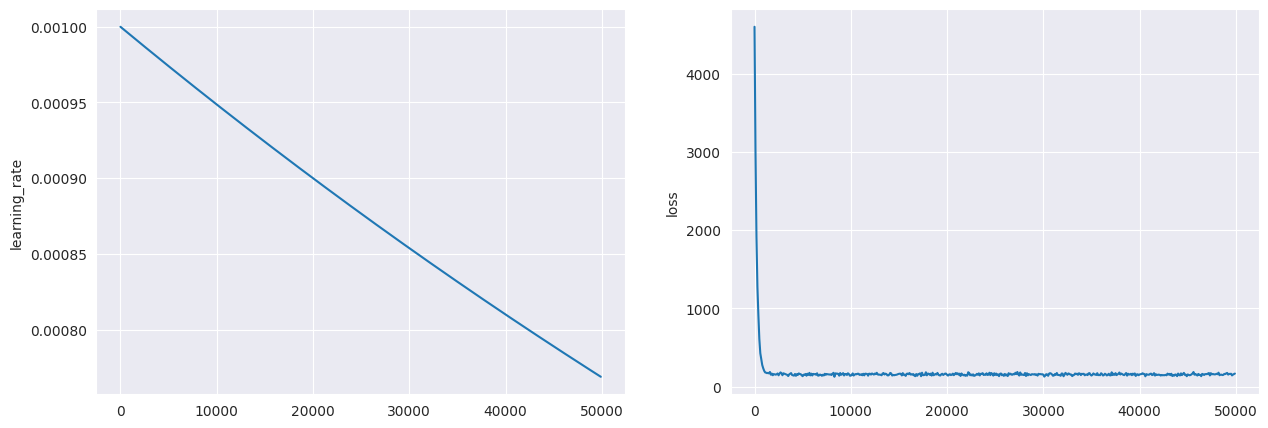

In [8]:
rng, key = jax.random.split(rng)
cv_model = train(key, loss_fn="diff", n_steps=50_000, l2_alpha=0.0)

generator = ScalarGenerator(grad_log_prob, cv_model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
cv_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

bias = true_pi - cv_estimates.mean()
std = cv_estimates.std()
print("diff:", bias, std)